# Setup

In [1]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

RAW_DIR = os.path.join(os.getcwd(), "data", "raw")
print(f"The raw data is located in the directory:\n{RAW_DIR}.")
BINNED_DIR = os.path.join(os.getcwd(), "data", "binned")
print(f"The binned data is located in the directory:\n{BINNED_DIR}.")

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
The raw data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned.


# Imports

In [2]:
#import default_config as config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Inspect Raw Data

In [3]:
import neuralgeom.datasets.utils as utils

expt_id = 34

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

INFO: Using pytorch backend


In [4]:
metadata = list(expt["x"].keys())
print(f"You can find metadata about:\n {metadata}.")

You can find metadata about:
 ['rat', 'day', 'epoch', 'type', 'finalGain', 'rosdata', 'clust', 'specGain'].


In [5]:
n_cells = len(expt["x"]["clust"])
print(f"There are {n_cells} cells/units/clusters recorded in this experiment.")

There are 40 cells/units/clusters recorded in this experiment.


## Define environmental variables

- startTs: 

- stopTs:

- encTimes:

- encAngle:

- supepochs:

- landAngle:

- gain:

- vel:

- relAngle:

- landOffTime:

- landOffAngle:

- landOffIdx:

- estGain:

- hippAngle:

# Load neural activity + measured lab variables ("labels")

In [18]:
import neuralgeom.datasets.experimental as experimental

expt_id = 34
timestep_microseconds = int(1e6)

neural_activity, labels = experimental.load_neural_activity(expt_id=expt_id, timestep_microsec=timestep_microseconds)

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

print(f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps")

INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_neural_activity_timestep1000000.npy! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep1000000.txt! Loading...


There are 40 neurons binned over 2953 timesteps


Visualize activity over time (PSTH) -- no speed thresholding

Text(0, 0.5, 'Lab angle (degrees)')

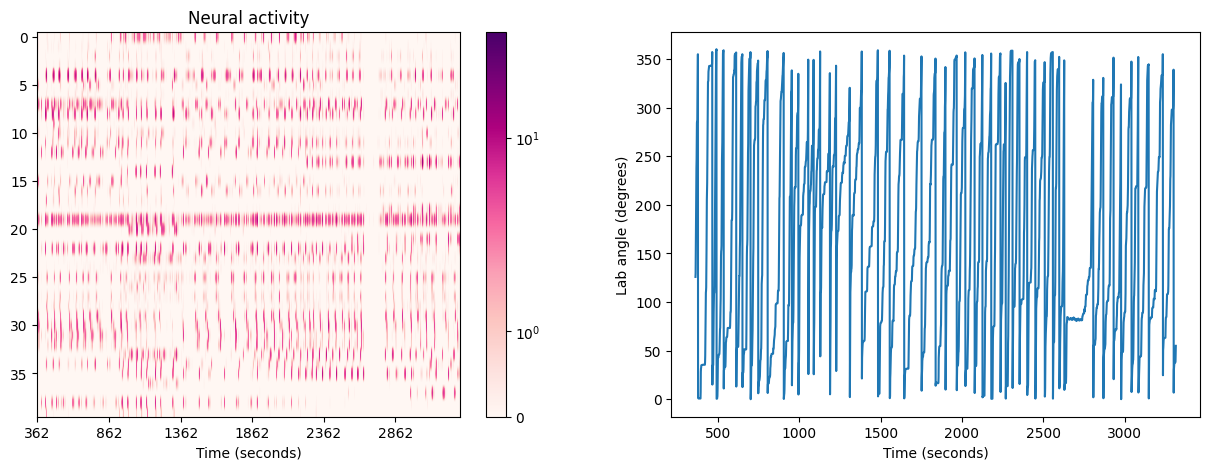

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

psth = axs[0].imshow(neural_activity.T, aspect="auto",cmap="RdPu",norm="symlog")
axs[0].set_title("Neural activity")
axs[0].set_xticks(np.arange(len(times_in_seconds))[::500])
axs[0].set_xticklabels(times_in_seconds[::500].astype(int))
axs[0].set_xlabel("Time (seconds)")

fig.colorbar(psth,ax=axs[0])

axs[1].plot(times_in_seconds, angles)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Lab angle (degrees)")

Set threshold velocity = 5 cm/s (place cell activity occurs when rat in motion)

In [19]:
neural_activity = neural_activity[labels["velocities"]>5]

labels = labels[labels["velocities"]>5]
print(f"There are {neural_activity.shape[0]} timesteps where the rat's speed was greater than 5 cm/s")

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

There are 934 timesteps where the rat's speed was greater than 5 cm/s


Visualize activity vs angles ("Peristimulus Angle Histogram")

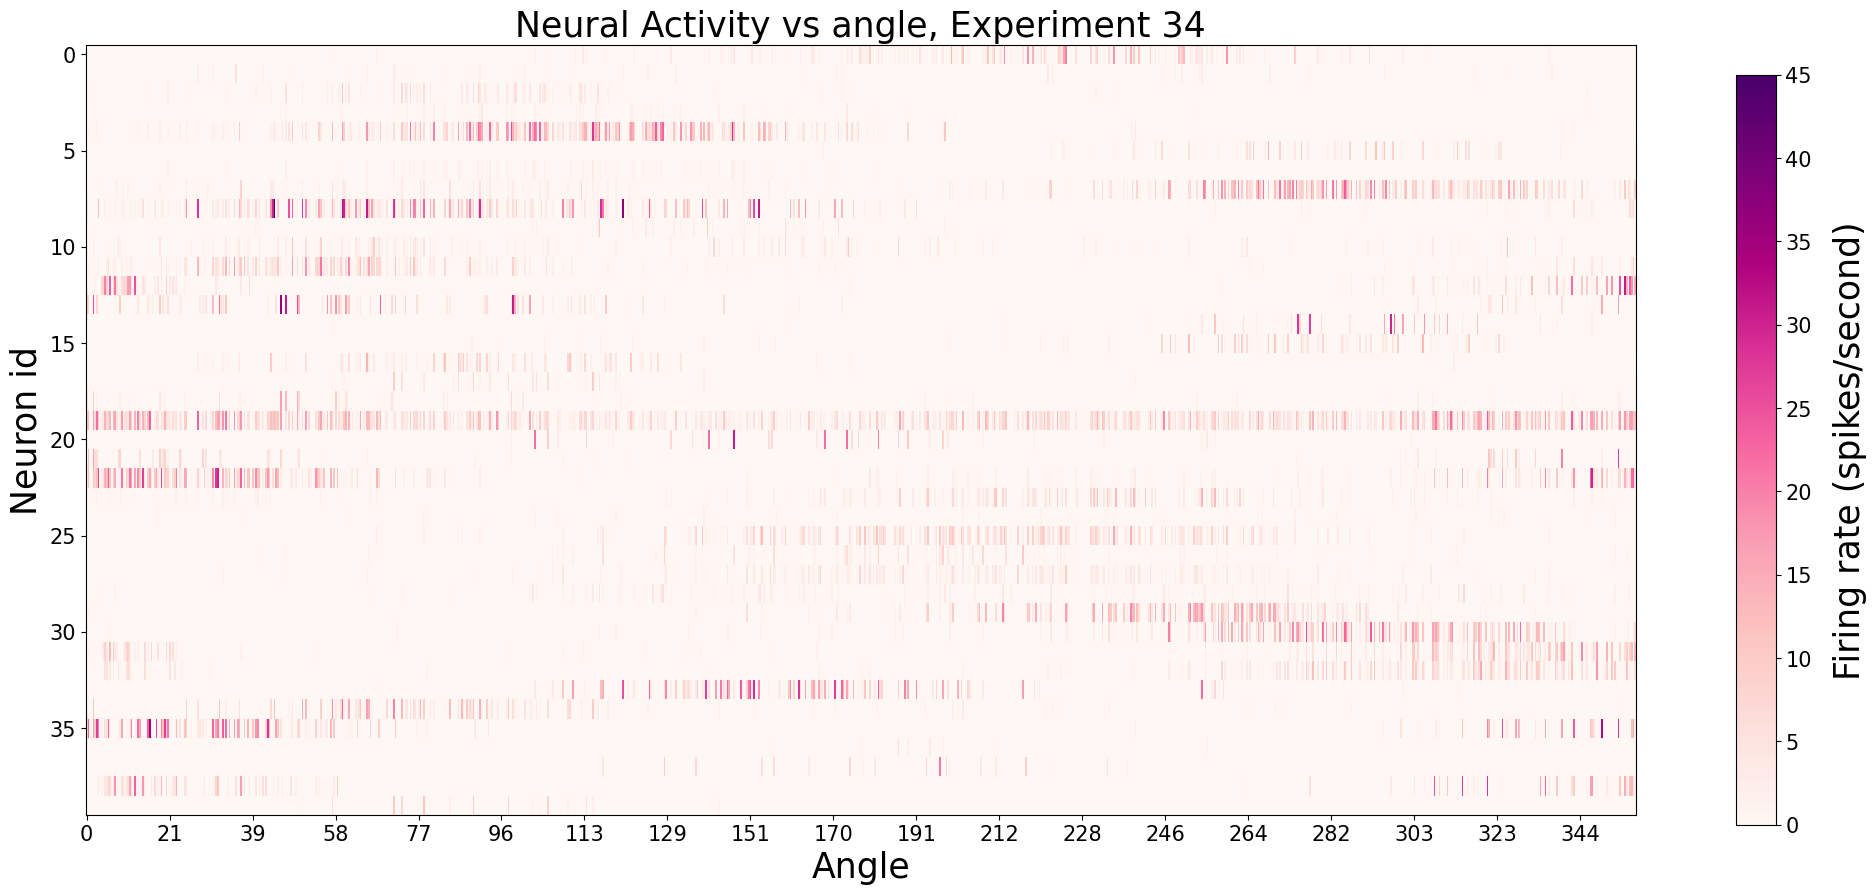

In [9]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]
fig, axs = plt.subplots(figsize=(20, 10))
psah = axs.imshow(sorted_neural_activity.T, aspect="auto",cmap="RdPu",interpolation="none")
axs.set_title(f"Neural Activity vs angle, Experiment {expt_id}",fontsize=25)
axs.set_xticks(np.arange(len(sorted_angles))[::50])
axs.set_xticklabels(sorted_angles[::50].astype(int))
axs.set_xlabel("Angle",fontsize=25)
axs.set_ylabel("Neuron id",fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=15)
# cbar = fig.colorbar(psah, ax=axs)
# cbar.set_label("Firing rate (spikes/second)", fontsize=15, rotation=0, labelpad=15)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(psah, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Smooth the binned data?

In [10]:
### CHECK THIS CODE

# from scipy.ndimage.filters import gaussian_filter1d

# # 'spike_times' is an array of times at which spikes occurred
# # To apply kernel smoothing, first create an array where each element represents a small time bin,
# # and the value is 1 if a spike occurred in that bin and 0 otherwise
# time_bins = np.arange(0, total_time, bin_width)
# spike_train = np.histogram(spike_times, bins=time_bins)[0]

# # Apply the Gaussian filter to smooth the spike train
# # 'sigma' is the standard deviation of the Gaussian kernel, in units of time bins
# sigma = 5  # for example
# smoothed_spike_train = gaussian_filter1d(spike_train.astype(float), sigma)

# # The smoothed spike train is now an estimate of the firing rate over time

## Run PCA

Find the eigenspectrum. How does it decay? --> Is the neural manifold "Smooth"?

## Train decoder FFNN

## Isolate "canonical" place cells

Calculate Mutual Information between angular position and activity for each neuron

In [33]:
from sklearn.feature_selection import mutual_info_regression

spatial_mutual_info = mutual_info_regression(neural_activity,angles)

In [34]:
spatial_mutual_info = mutual_info_regression(neural_activity,angles)

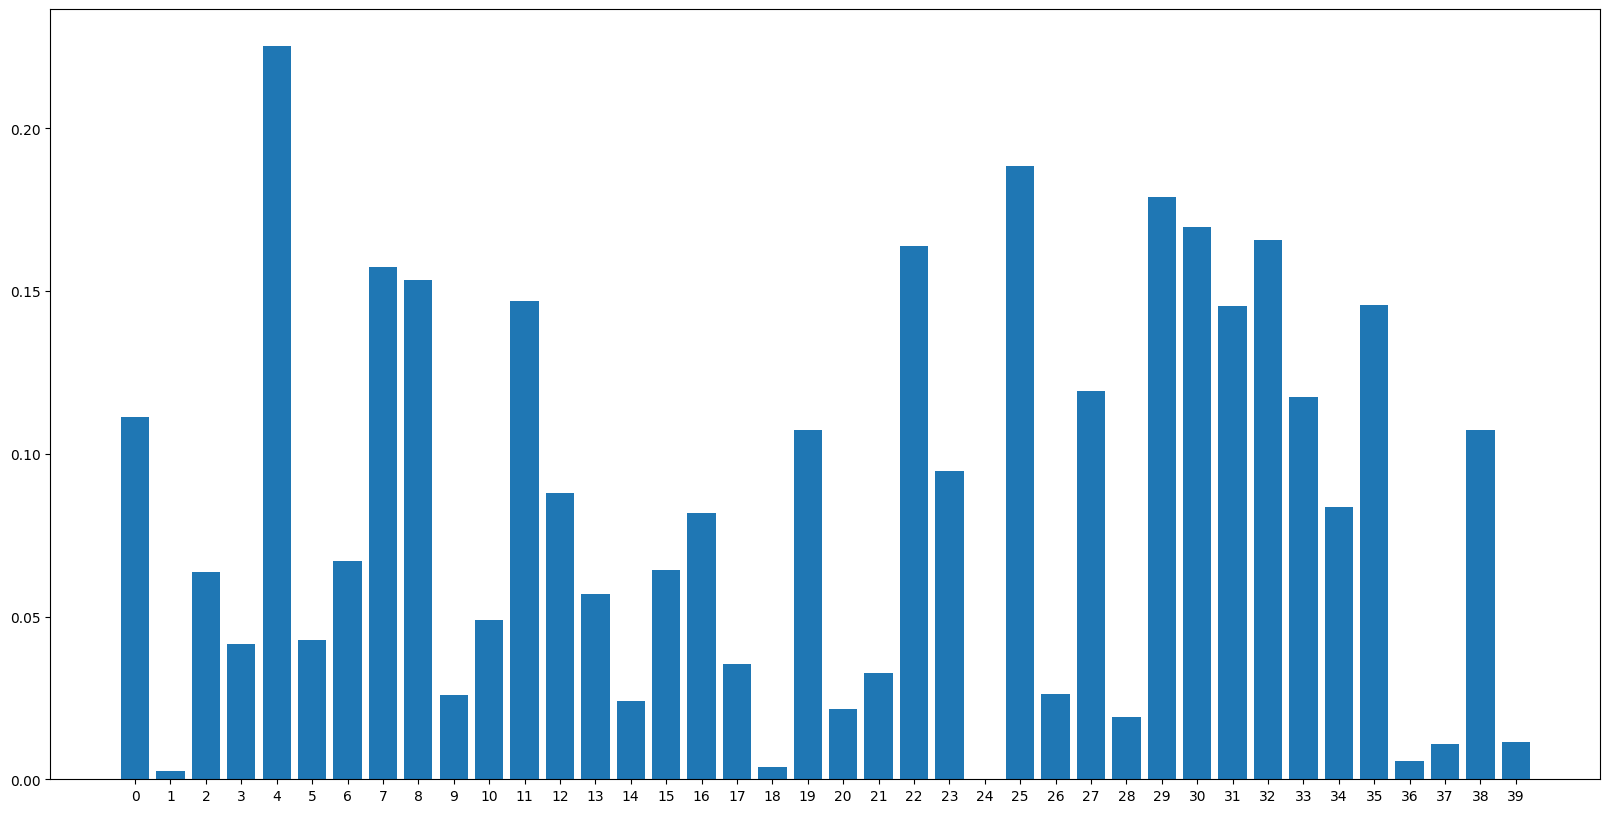

In [35]:
x_ticks = np.arange(0,len(spatial_mutual_info))

fig, ax = plt.subplots(figsize=(20,10))

# Plot the barograph
ax.bar(x_ticks, spatial_mutual_info)

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks);

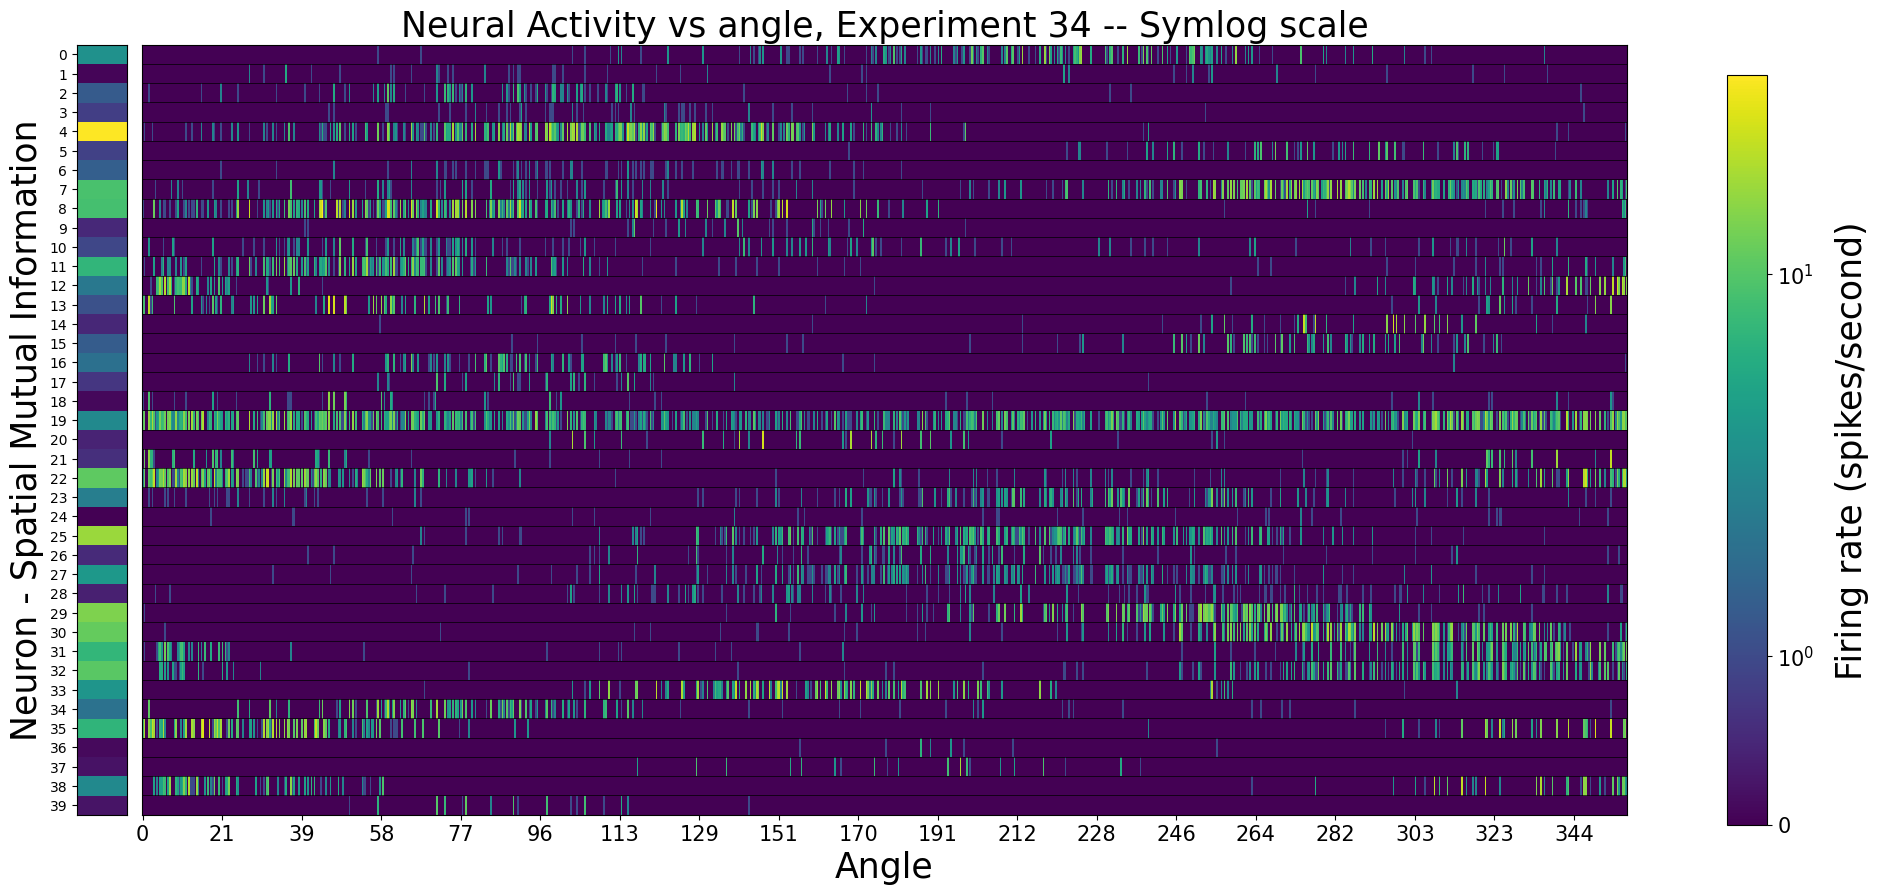

In [14]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = spatial_mutual_info

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(sorted_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

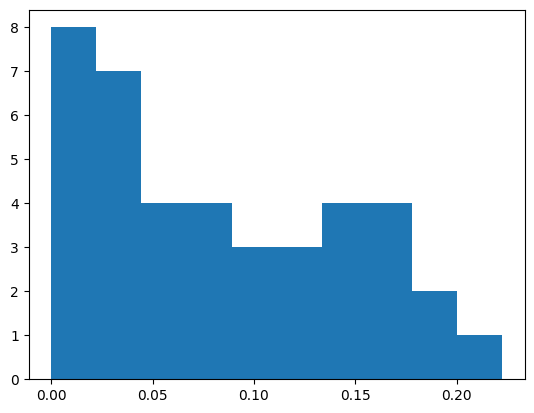

In [29]:
hist = plt.hist(spatial_mutual_info)

Set Spatial Mutual Information threshold

In [22]:
mi_threshold = 0.1

In [23]:
high_mi_neural_activity = neural_activity[:,spatial_mutual_info>mi_threshold]
high_mi_spatial_mutual_info = spatial_mutual_info[spatial_mutual_info>mi_threshold]

In [25]:
high_mi_neural_activity.shape

(934, 16)

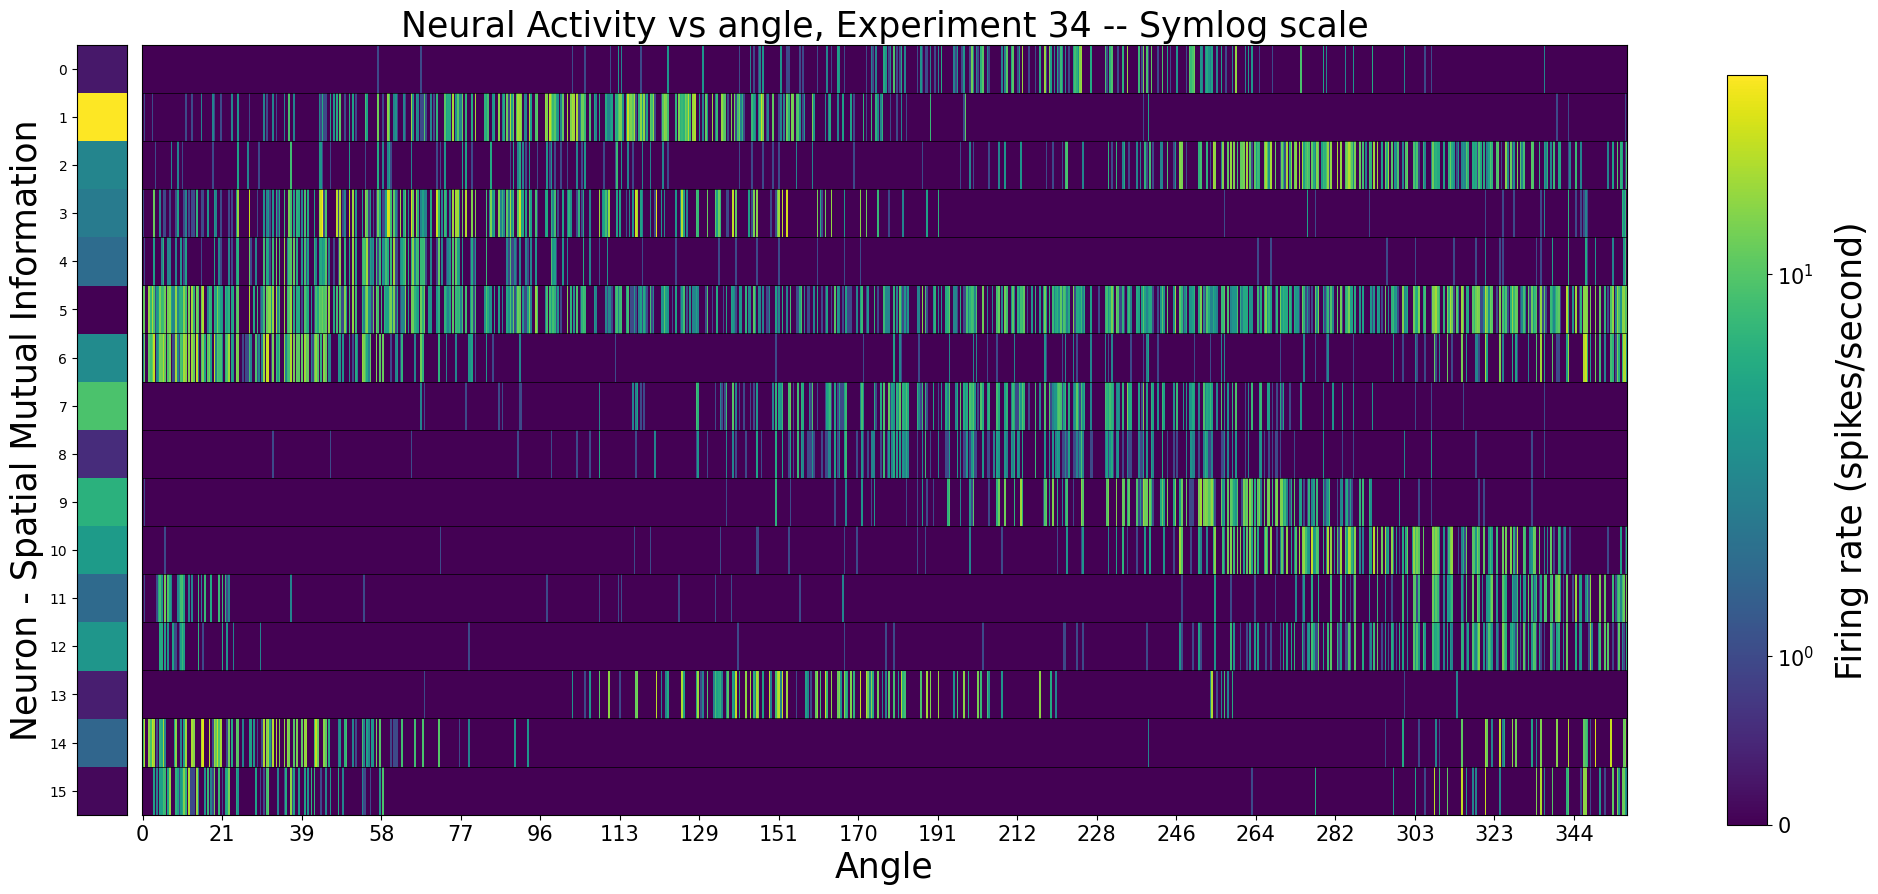

In [36]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_high_mi_neural_activity = high_mi_neural_activity[sort, :]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = high_mi_spatial_mutual_info

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(high_mi_spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(sorted_high_mi_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_high_mi_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)

In [ ]:
weighted_center_of_mass = np.average(points, weights=weights)

center_of_mass_index = np.argmax(weights)

In [68]:
weights = sorted_high_mi_neural_activity.T

points = np.tile(sorted_angles,(weights.shape[0], 1))

weighted_center_of_mass = np.average(points, weights=weights, axis=1)

center_of_mass_indices = np.argmax(weights, axis=1)

In [69]:
center_of_mass_indices

array([590, 389, 758, 113, 141, 844,  79, 619, 590, 552, 735, 901, 910,
       402,  38, 844])

In [70]:
com_sort = np.argsort(center_of_mass_indices)

organized_neural_activity = sorted_high_mi_neural_activity[:,com_sort]

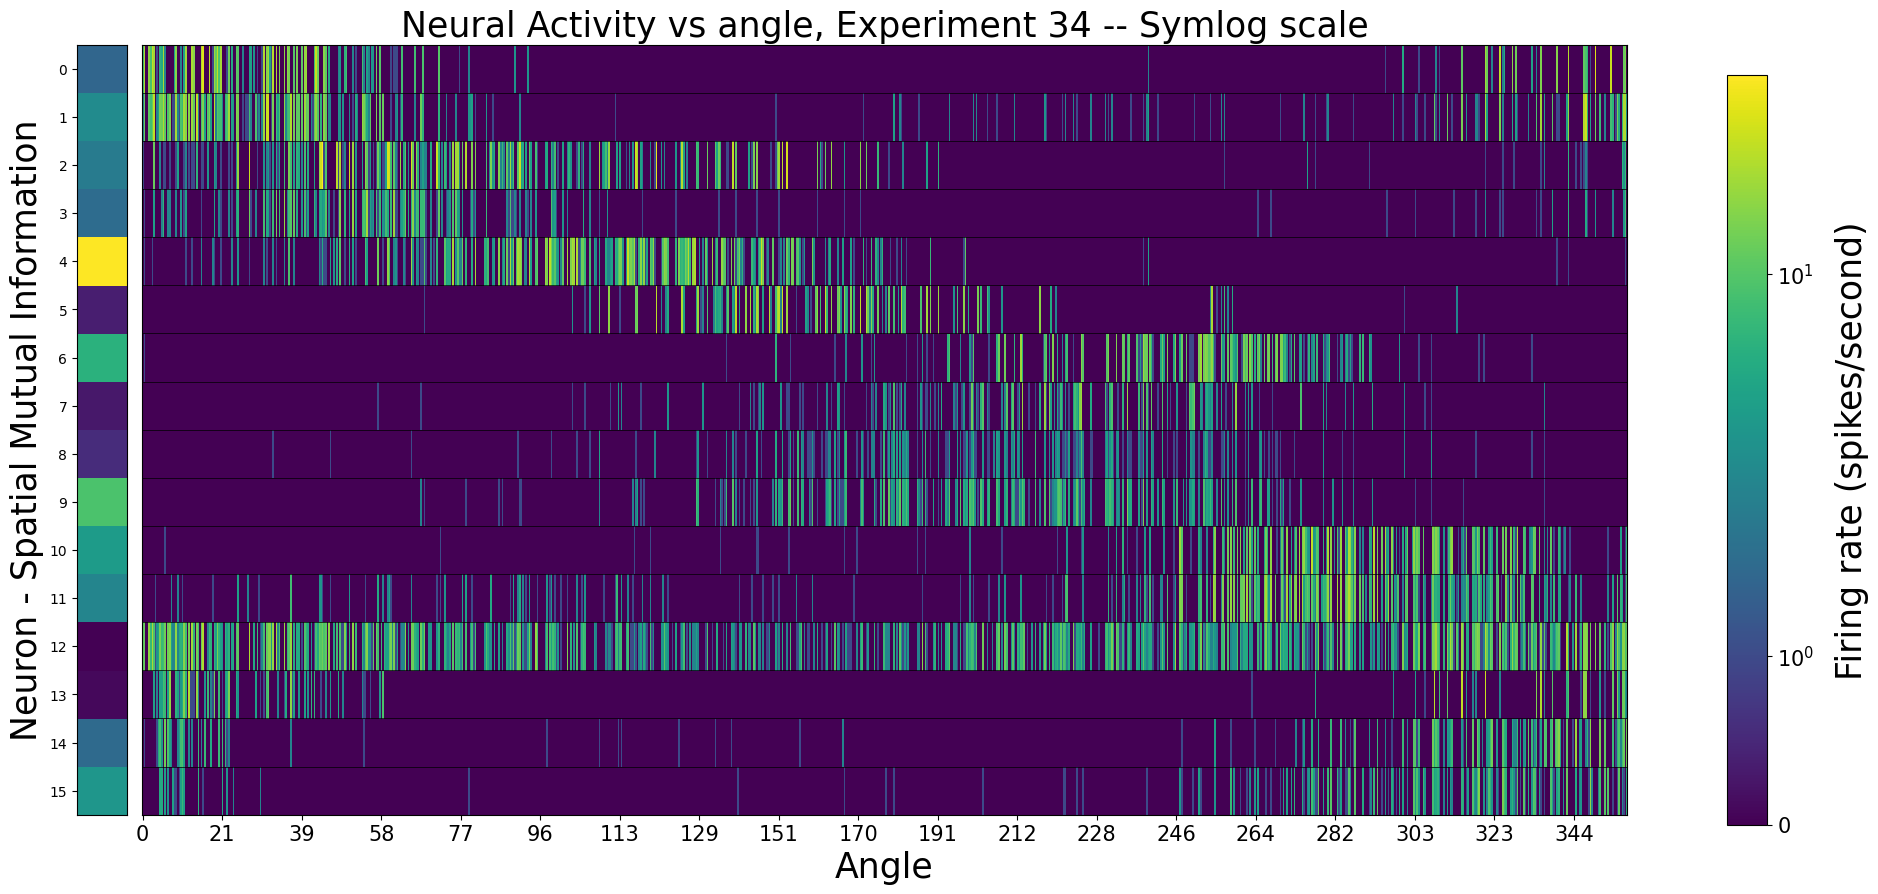

In [74]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 30]}, figsize=(20,10))

vector = high_mi_spatial_mutual_info[com_sort]

img1 = ax1.imshow(vector[:, np.newaxis], aspect='auto', cmap='viridis', vmin=vector.min(), vmax=vector.max())
ax1.set_ylabel("Neuron - Spatial Mutual Information",fontsize=25)
ax1.set_yticks(np.arange(0,len(high_mi_spatial_mutual_info)))
ax1.set_xticks([])



img2 = ax2.imshow(organized_neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation='none')
ax2.set_yticks([])
ax2.set_title(f"Neural Activity vs angle, Experiment {expt_id} -- Symlog scale",fontsize=25)
ax2.set_xticks(np.arange(len(sorted_angles))[::50])
ax2.set_xticklabels(sorted_angles[::50].astype(int))
ax2.set_xlabel("Angle",fontsize=25)

for i in range(len(sorted_high_mi_neural_activity.T)):
    ax2.axhline(i-0.5, color='black', lw=0.5)

ax2.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(wspace=0.02)

# Create a new axis for the colorbar at the bottom
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])

# Add a colorbar with label
cbar = fig.colorbar(img2, cax=cbar_ax, orientation='vertical')
cbar.set_label('Firing rate (spikes/second)', fontsize=25, labelpad=15)
cbar_ax.tick_params(axis='both', which='major', labelsize=15)